In [1]:
from Helpers import *
from ILQGController import *
from FLController import *
from LQGController import *
#alacon

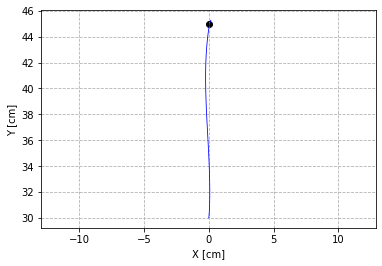

In [20]:
w1 = 1e7
w2 = 1e4
r1 = 1e-4
x=ILQG(.6,w1,w2,r1,targets=[0,45],K = 60,start = [0,30],alpha = 1e-4,multvar=1e-3,Noise=True)

In [ ]:
def Plot_8_Target(K = 60,Noise = False,ClassicLQG = False):
    Duration = .6
    w1 = 1e7
    w2 = 1e4
    r1 = 1e-4
    d = 14.285
    start = [0,35]
    fig,ax = plt.subplots(figsize = (6,6),dpi = 600)
    TARG = [[0,55],[0,15],[20,35],[-20,35],[d,35+d],[d,35-d],[-d,35-d],[-d,35+d]]
    TEXTE = [[0,56],[0,12],[21,35],[-22,35],[d+.5,35+d+.5],[d+.5,35-d-2.5],[-d-1.5,35-d-2.5],[-d-1.5,35+d+.5]]
    for i in range(8):
        targets = TARG[i]
        plt.text(TEXTE[i][0],TEXTE[i][1],str(i))
        if ClassicLQG == True : xILQG,yILQG,_ = LQG(Duration,w1,w1,w2,w2,r1,r1,targets,Num_iter=60,starting_point=start,Activate_Noise = True,alpha = 1e-3)
        else : 
            xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,60,start,Noise = Noise,Variance=1e-6)
            J = 0
            R = np.array([[r1,0],[0,r1]])
            for j in range(K-1):
                J+= uILQG[j].T@R@uILQG[j]
            

            print("Total cost ILQG: "+str(J))   

            
        #X,Y,_ = LQG(Duration,w1,w1,w2,w2,r1,r1,targets,start,Num_iter = K,Activate_Noise = True)
        X,Y = Feedback_Linearization(Duration,w1,w1,w2,w2,r1,r1,targets,start,Num_iter = 60,Activate_Noise=True,ShowJ= False,Delay =0,FF = False,alpha = 1)

    hand, labl = ax.get_legend_handles_labels()
    handout=[]
    lablout=[]
    for h,l in zip(hand,labl):
        if l not in lablout:
            lablout.append(l)
            handout.append(h)
    fig.legend(handout, lablout)
    plt.xlim(-25,25)
    plt.ylim(10,60)
    plt.show()

In [ ]:
def Compute_Speed(X,Y,dt):
    V = np.zeros(X.shape[0])
    for i in range(X.shape[0]-1):
        V[i+1] = np.sqrt(((X[i+1]-X[i])/dt)**2+((Y[i+1]-Y[i])/dt)**2)
    return V

def Plot_Speed(K = 60,Noise = False,ClassicLQG = False,NumTarg = 8,TargStart = 0,L = 20):
    Duration = .6
    fig,ax = plt.subplots(NumTarg,figsize=(8,8+3*(NumTarg-1)))
    w1 = 1e7
    w2 = 1e4
    r1 = 1e-4
    d = np.sqrt(L**2/2)
    start = [0,35]
    TARG = [[0,55],[0,15],[20,35],[-20,35],[d,35+d],[d,35-d],[-d,35-d],[-d,35+d]]
    TEXTE = [[0,56],[0,12],[21,35],[-22,35],[d+.5,35+d+.5],[d+.5,35-d-2.5],[-d-1.5,35-d-2.5],[-d-1.5,35+d+.5]]
    for i in range(TargStart,TargStart+NumTarg):
        targets = TARG[i]
        if ClassicLQG == True : 
            xILQG,yILQG,_ = LQG(Duration,w1,w1,w2,w2,r1,r1,targets,Num_iter=60,starting_point=start,Activate_Noise = Noise,alpha = 1e-3,plot= False)
            
        else : 
            xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,60,start,Noise = Noise,Variance=1e-6,plot= False)
            J = 0
            R = np.array([[r1,0],[0,r1]])
            for j in range(K-1):
                J+= uILQG[j].T@R@uILQG[j]
            

            print("Total cost ILQG: "+str(J))   
        
        V = Compute_Speed(xILQG,yILQG,Duration/K)
        if NumTarg > 1 :
            ax[i].plot(np.arange(0,Duration,Duration/K)[:-1],V,label = "LQG")   
            #X,Y,_ = LQG(Duration,w1,w1,w2,w2,r1,r1,targets,start,Num_iter = K,Activate_Noise = True)
            X,Y,u,J = Feedback_Linearization(Duration,w1,w1,w2,w2,r1,r1,targets,start,Num_iter = 60,Activate_Noise=Noise,ShowJ= True,Delay =0,FF = False,alpha = .08,plot = False)
            V = Compute_Speed(X,Y,Duration/K)
            ax[i].plot(np.arange(0,Duration,Duration/K),V,label = "FL") 
            ax[i].set_title("Target "+str(i))
            ax[i].legend()
            ax[i].set_xlabel("Time [s]")
            ax[i].set_ylabel("Velocity [m/s]")
        else : 
            ax.plot(np.arange(0,Duration,Duration/K)[:-1],V,label = "LQG")   
            #X,Y,_ = LQG(Duration,w1,w1,w2,w2,r1,r1,targets,start,Num_iter = K,Activate_Noise = True)
            X,Y,u,J = Feedback_Linearization(Duration,w1,w1,w2,w2,r1,r1,targets,start,Num_iter = 60,Activate_Noise=Noise,ShowJ= True,Delay =0,FF = False,alpha = .08,plot = False)
            V = Compute_Speed(X,Y,Duration/K)
            ax.plot(np.arange(0,Duration,Duration/K),V,label = "FL") 
            ax.set_title("Target "+str(i))
            ax.set_xlabel("Time [s]")
            ax.set_ylabel("Velocity [m/s]")
            ax.legend()
    plt.show()

Total cost of FL: 0.01507


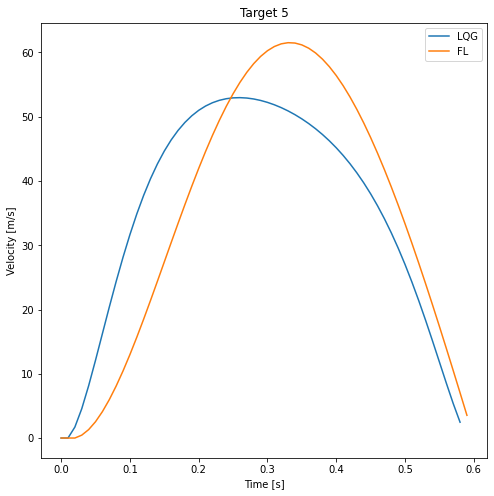

In [80]:
Plot_Speed(ClassicLQG=True,NumTarg = 1,TargStart = 5)

Total cost of FL: 0.00807


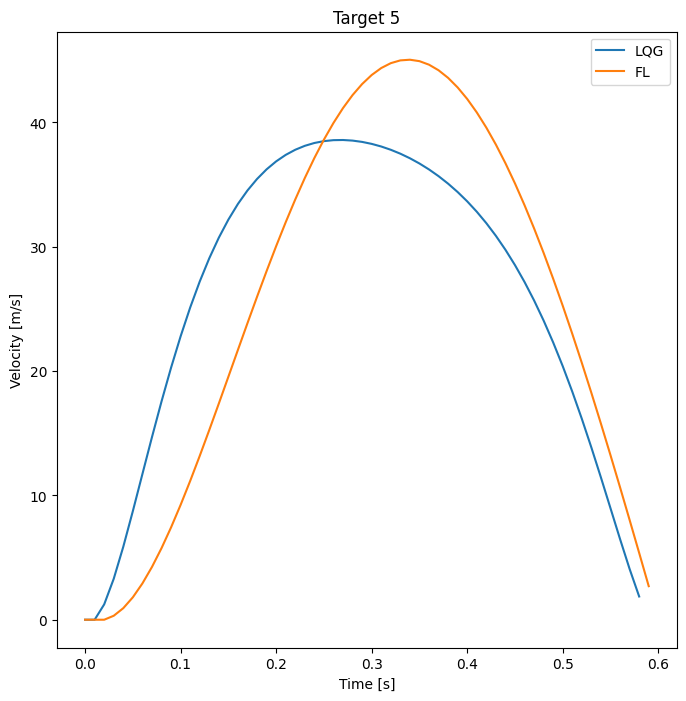

In [10]:
Plot_Speed(ClassicLQG=True,NumTarg = 1,TargStart = 5, L = 15)

Total cost ILQG: 0.00835916054240203
Total cost of FL: 0.00992
Total cost ILQG: 0.005989986803645634
Total cost of FL: 0.00733
Total cost ILQG: 0.005467046964720924
Total cost of FL: 0.00737
Total cost ILQG: 0.009408408277047397
Total cost of FL: 0.01254
Total cost ILQG: 0.003647433901983947
Total cost of FL: 0.00444
Total cost ILQG: 0.011998602935241204
Total cost of FL: 0.01507
Total cost ILQG: 0.004878849310519756
Total cost of FL: 0.00583
Total cost ILQG: 0.011533680435456706
Total cost of FL: 0.01552


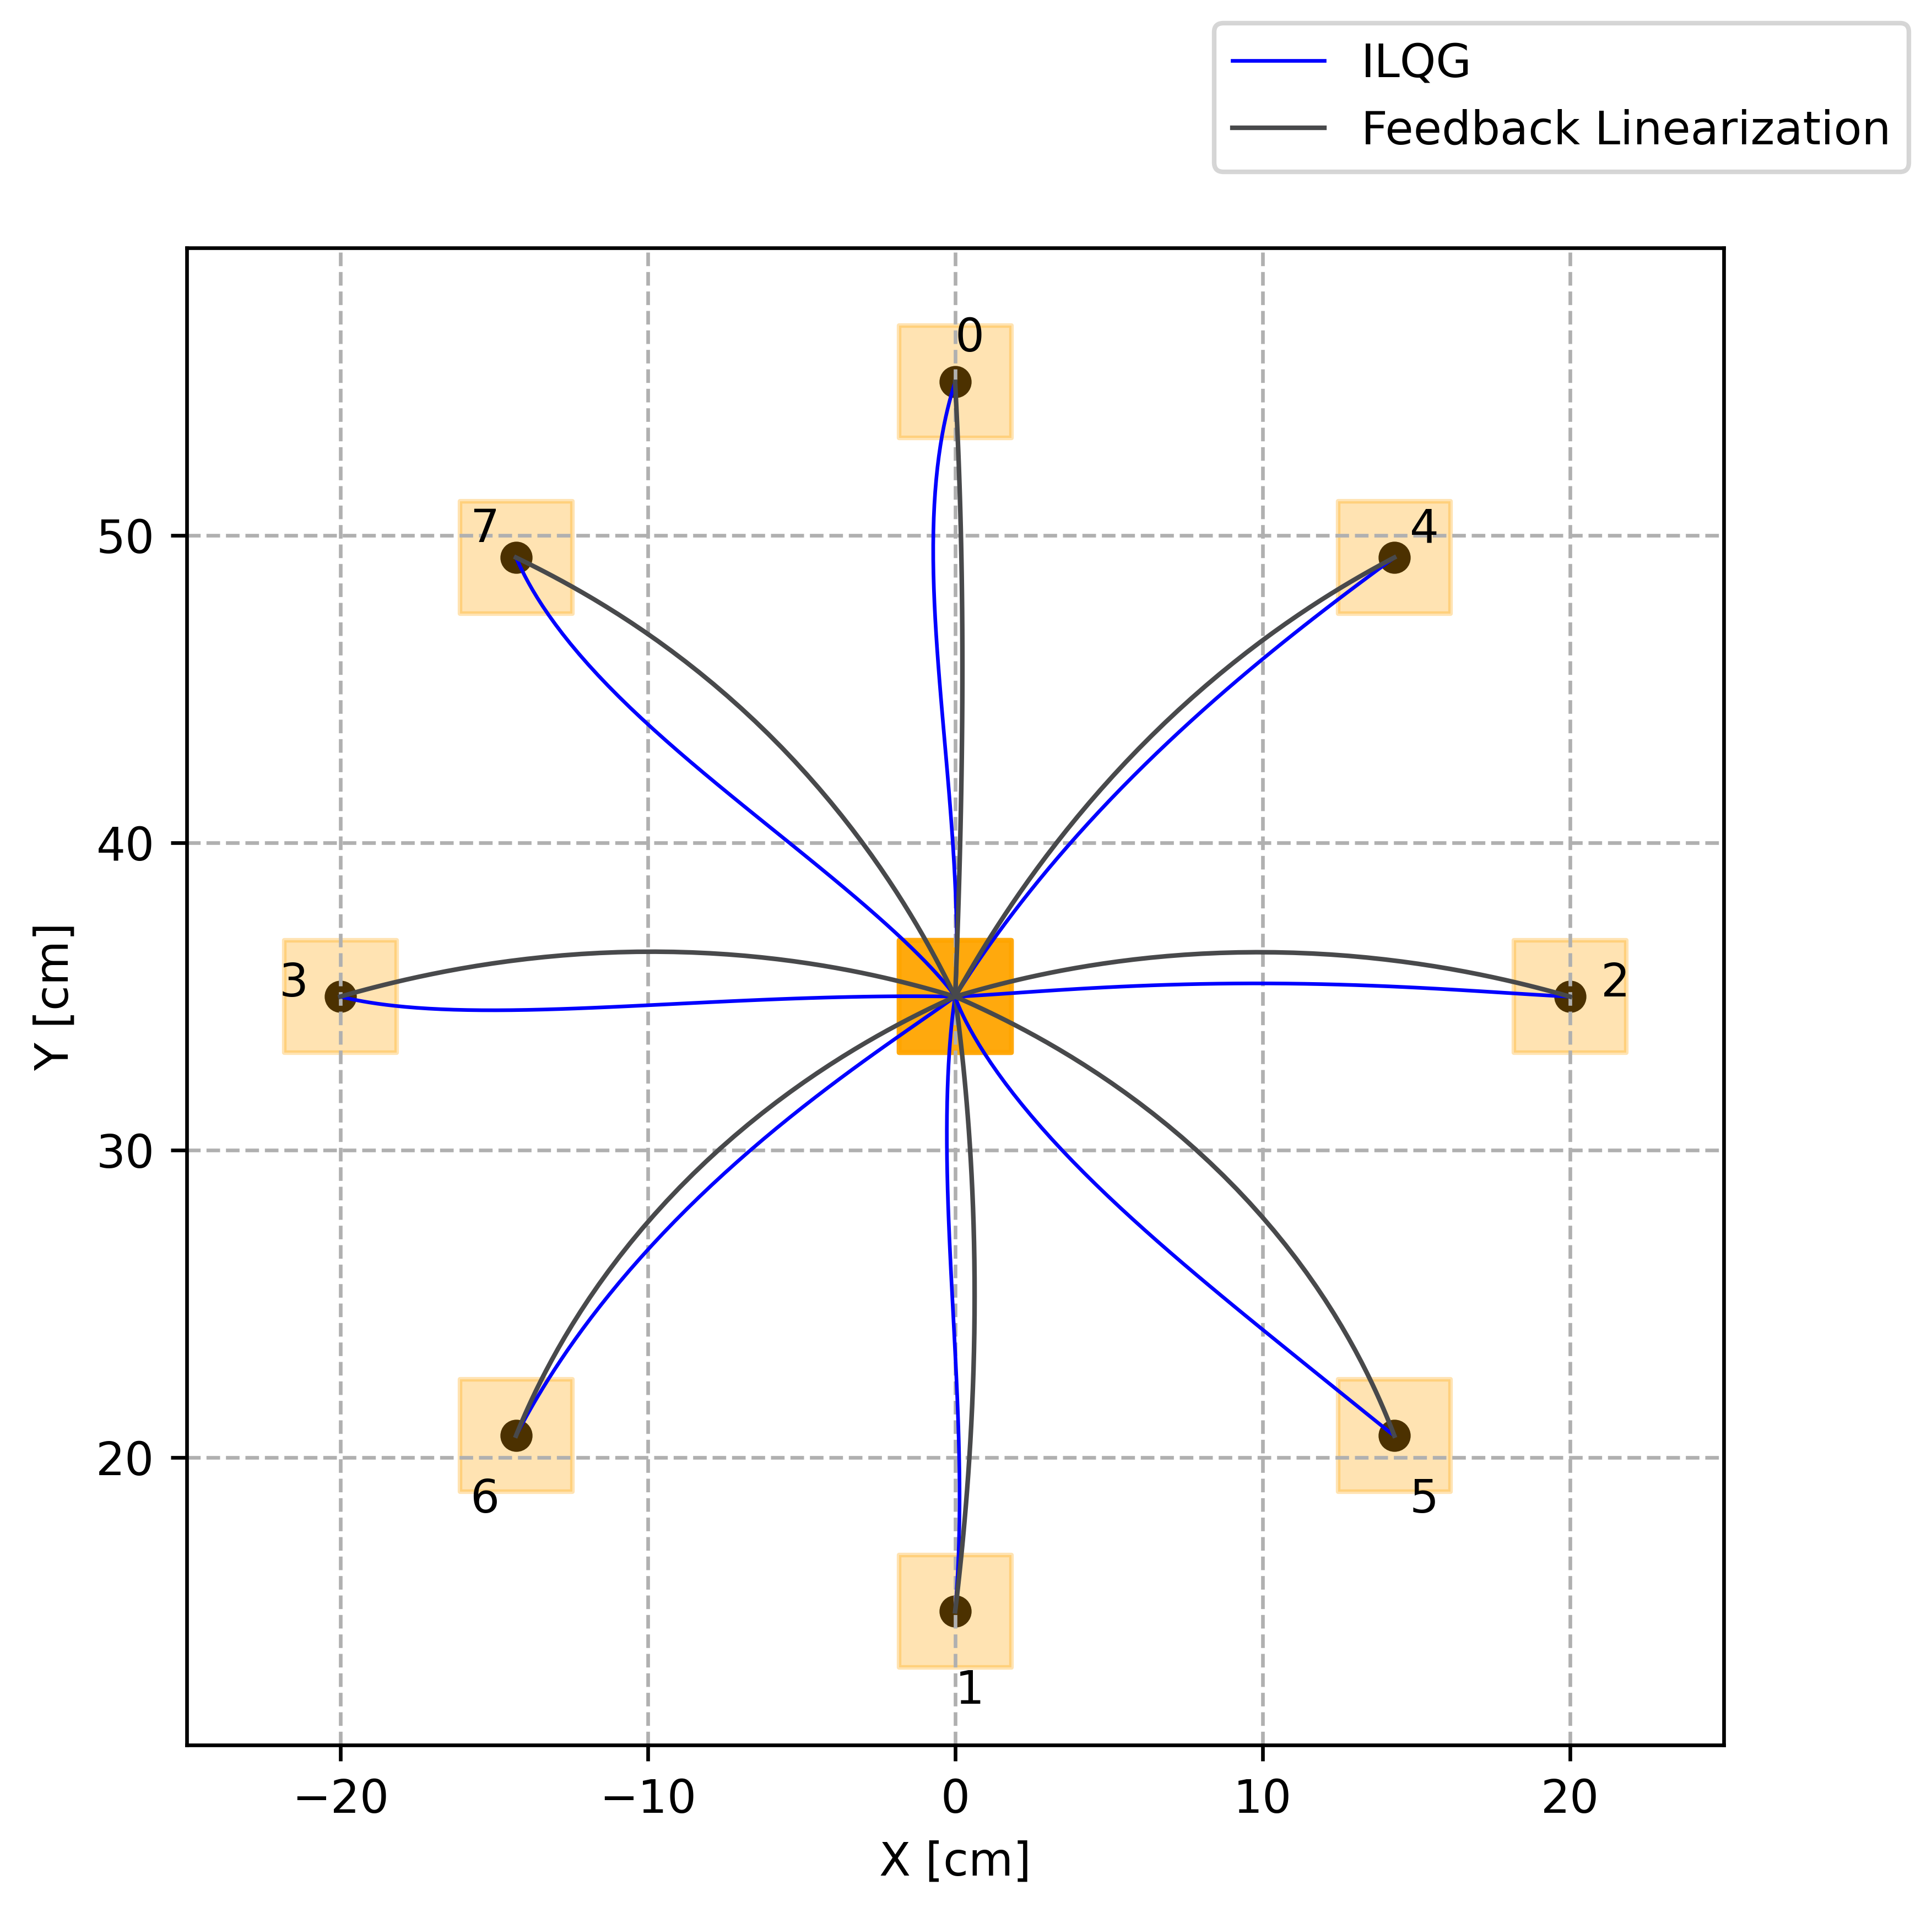

In [7]:
Plot_8_Target()

Total cost ILQG: 0.00835916054240203
Total cost ILQG: 0.005989986803645634
Total cost ILQG: 0.005467046964720924
Total cost ILQG: 0.009408408277047397
Total cost ILQG: 0.003647433901983947
Total cost ILQG: 0.011998602935241204
Total cost ILQG: 0.004878849310519756
Total cost ILQG: 0.011533680435456706


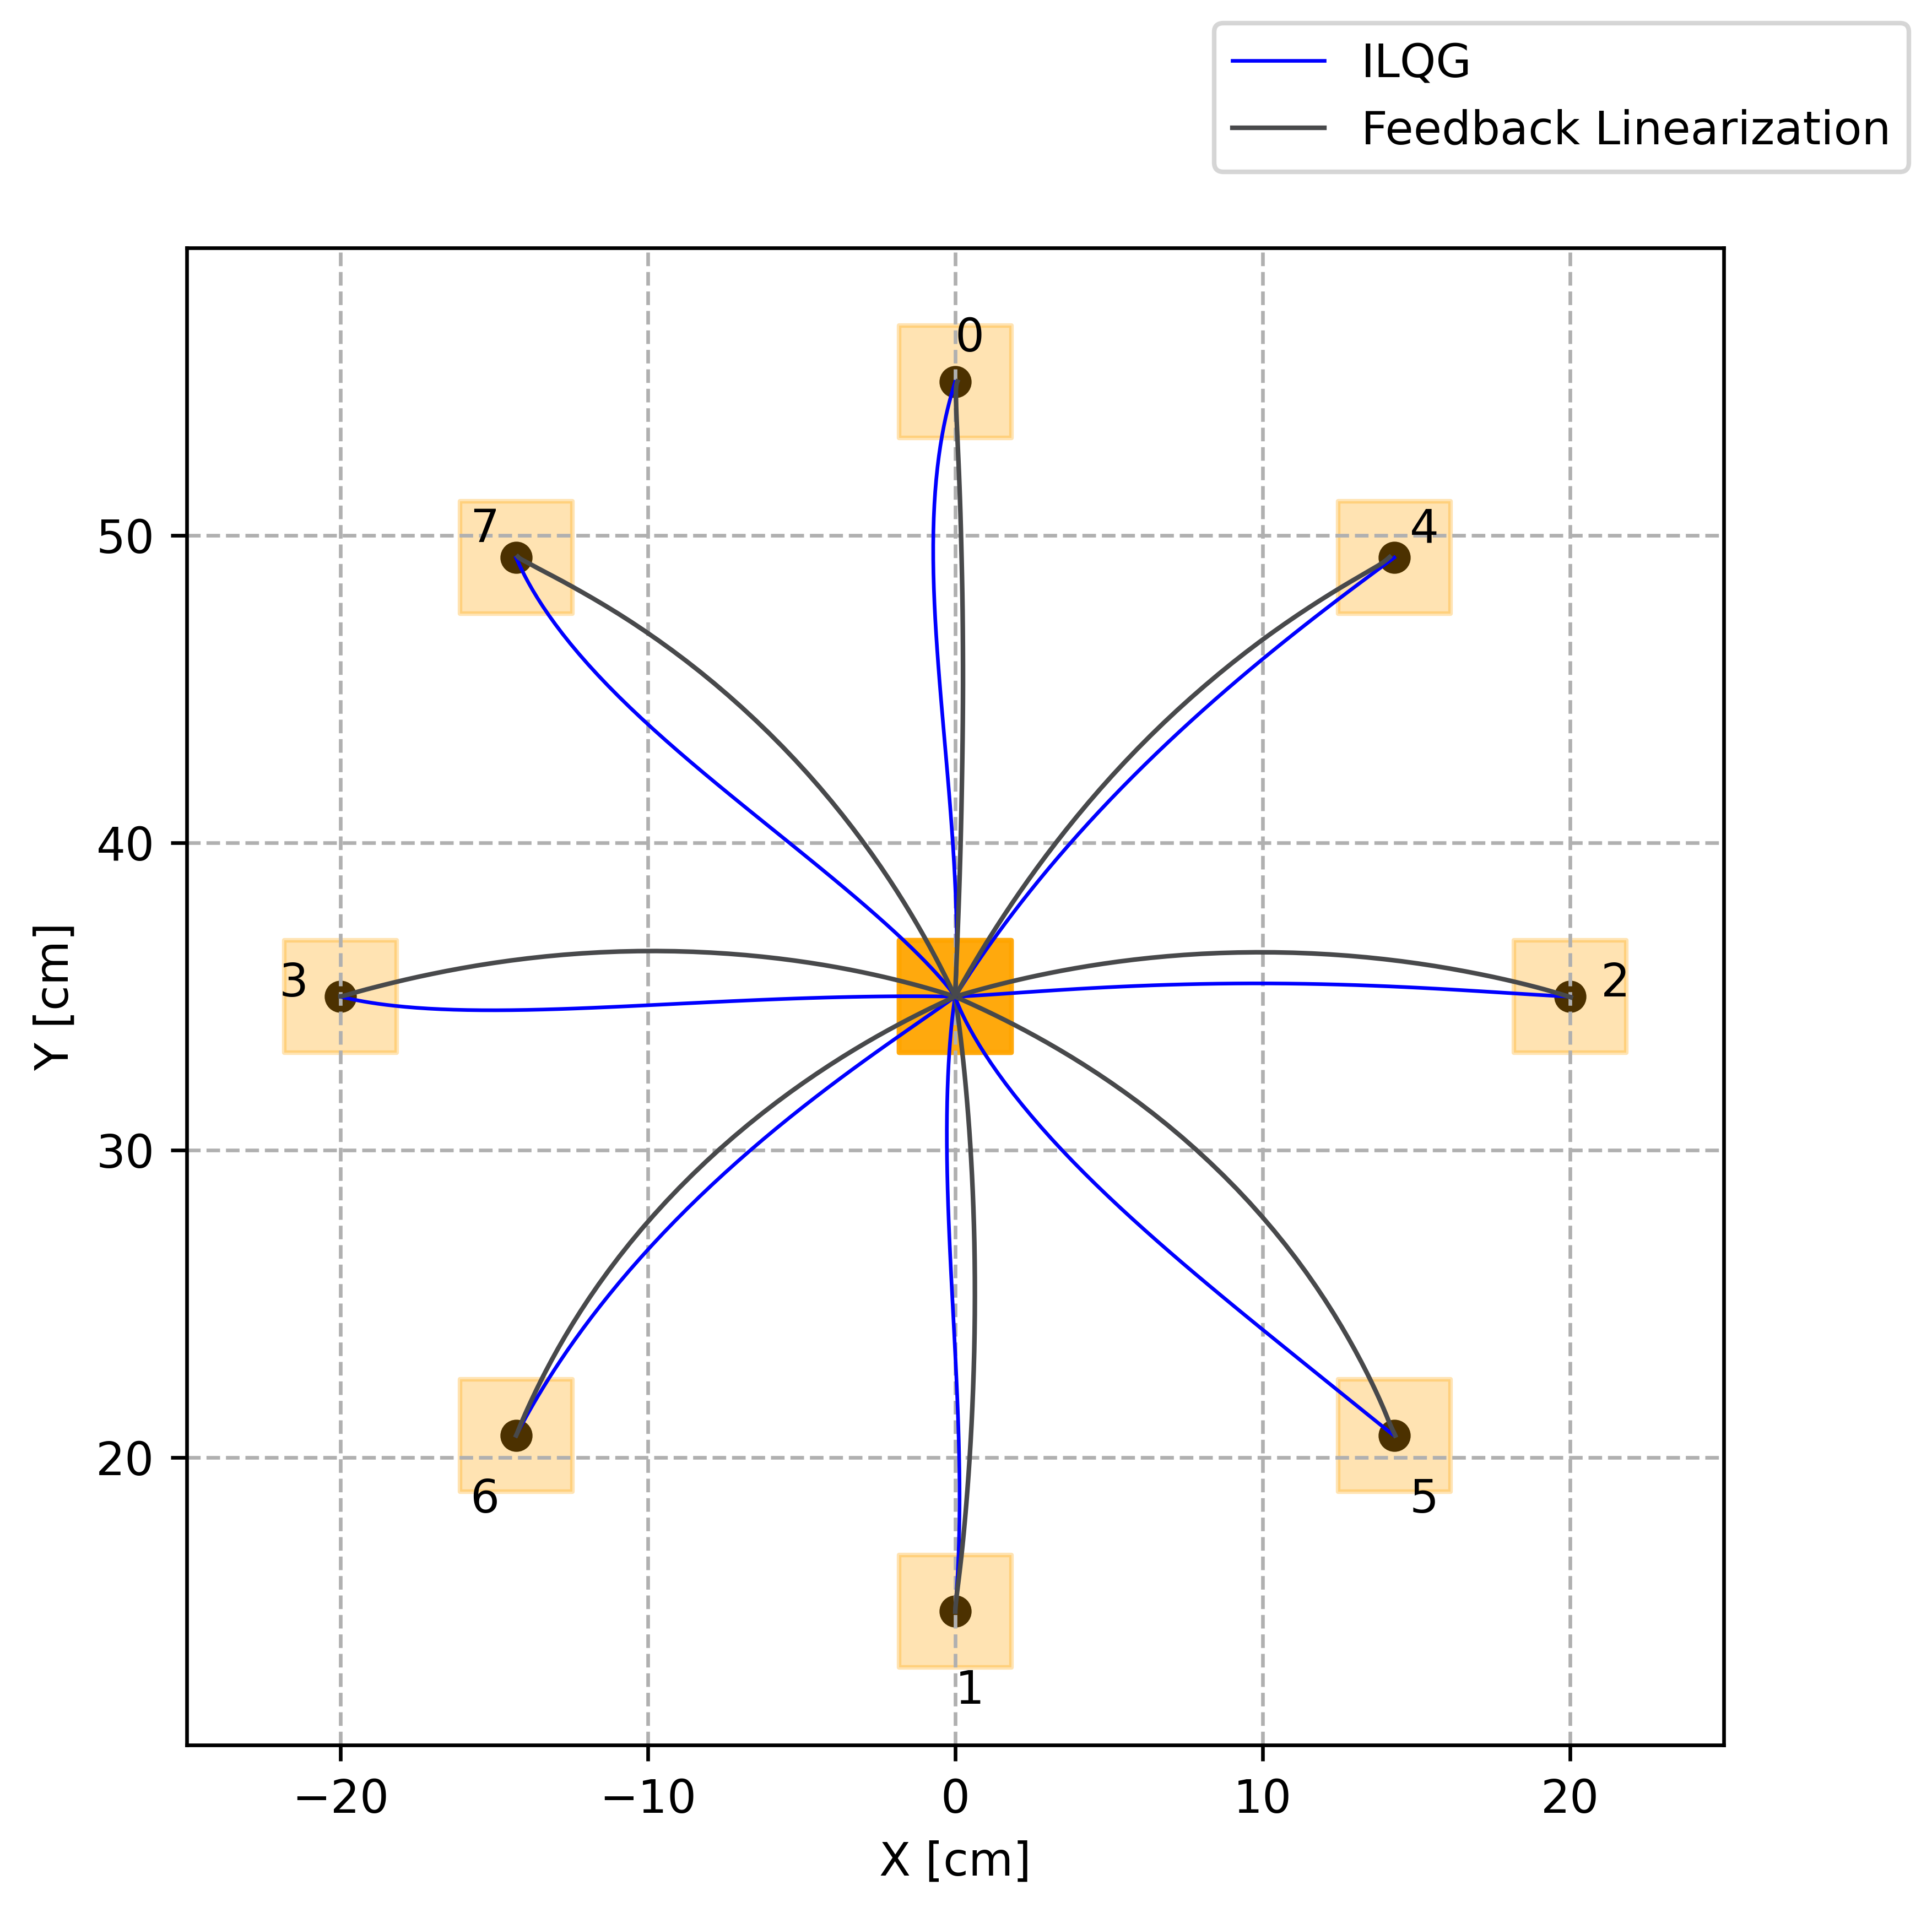

In [12]:
Plot_8_Target(Noise = True)

Total cost of FL: 0.00992
Total cost of FL: 0.00733
Total cost of FL: 0.00737
Total cost of FL: 0.01254
Total cost of FL: 0.00444
Total cost of FL: 0.01507
Total cost of FL: 0.00583
Total cost of FL: 0.01552


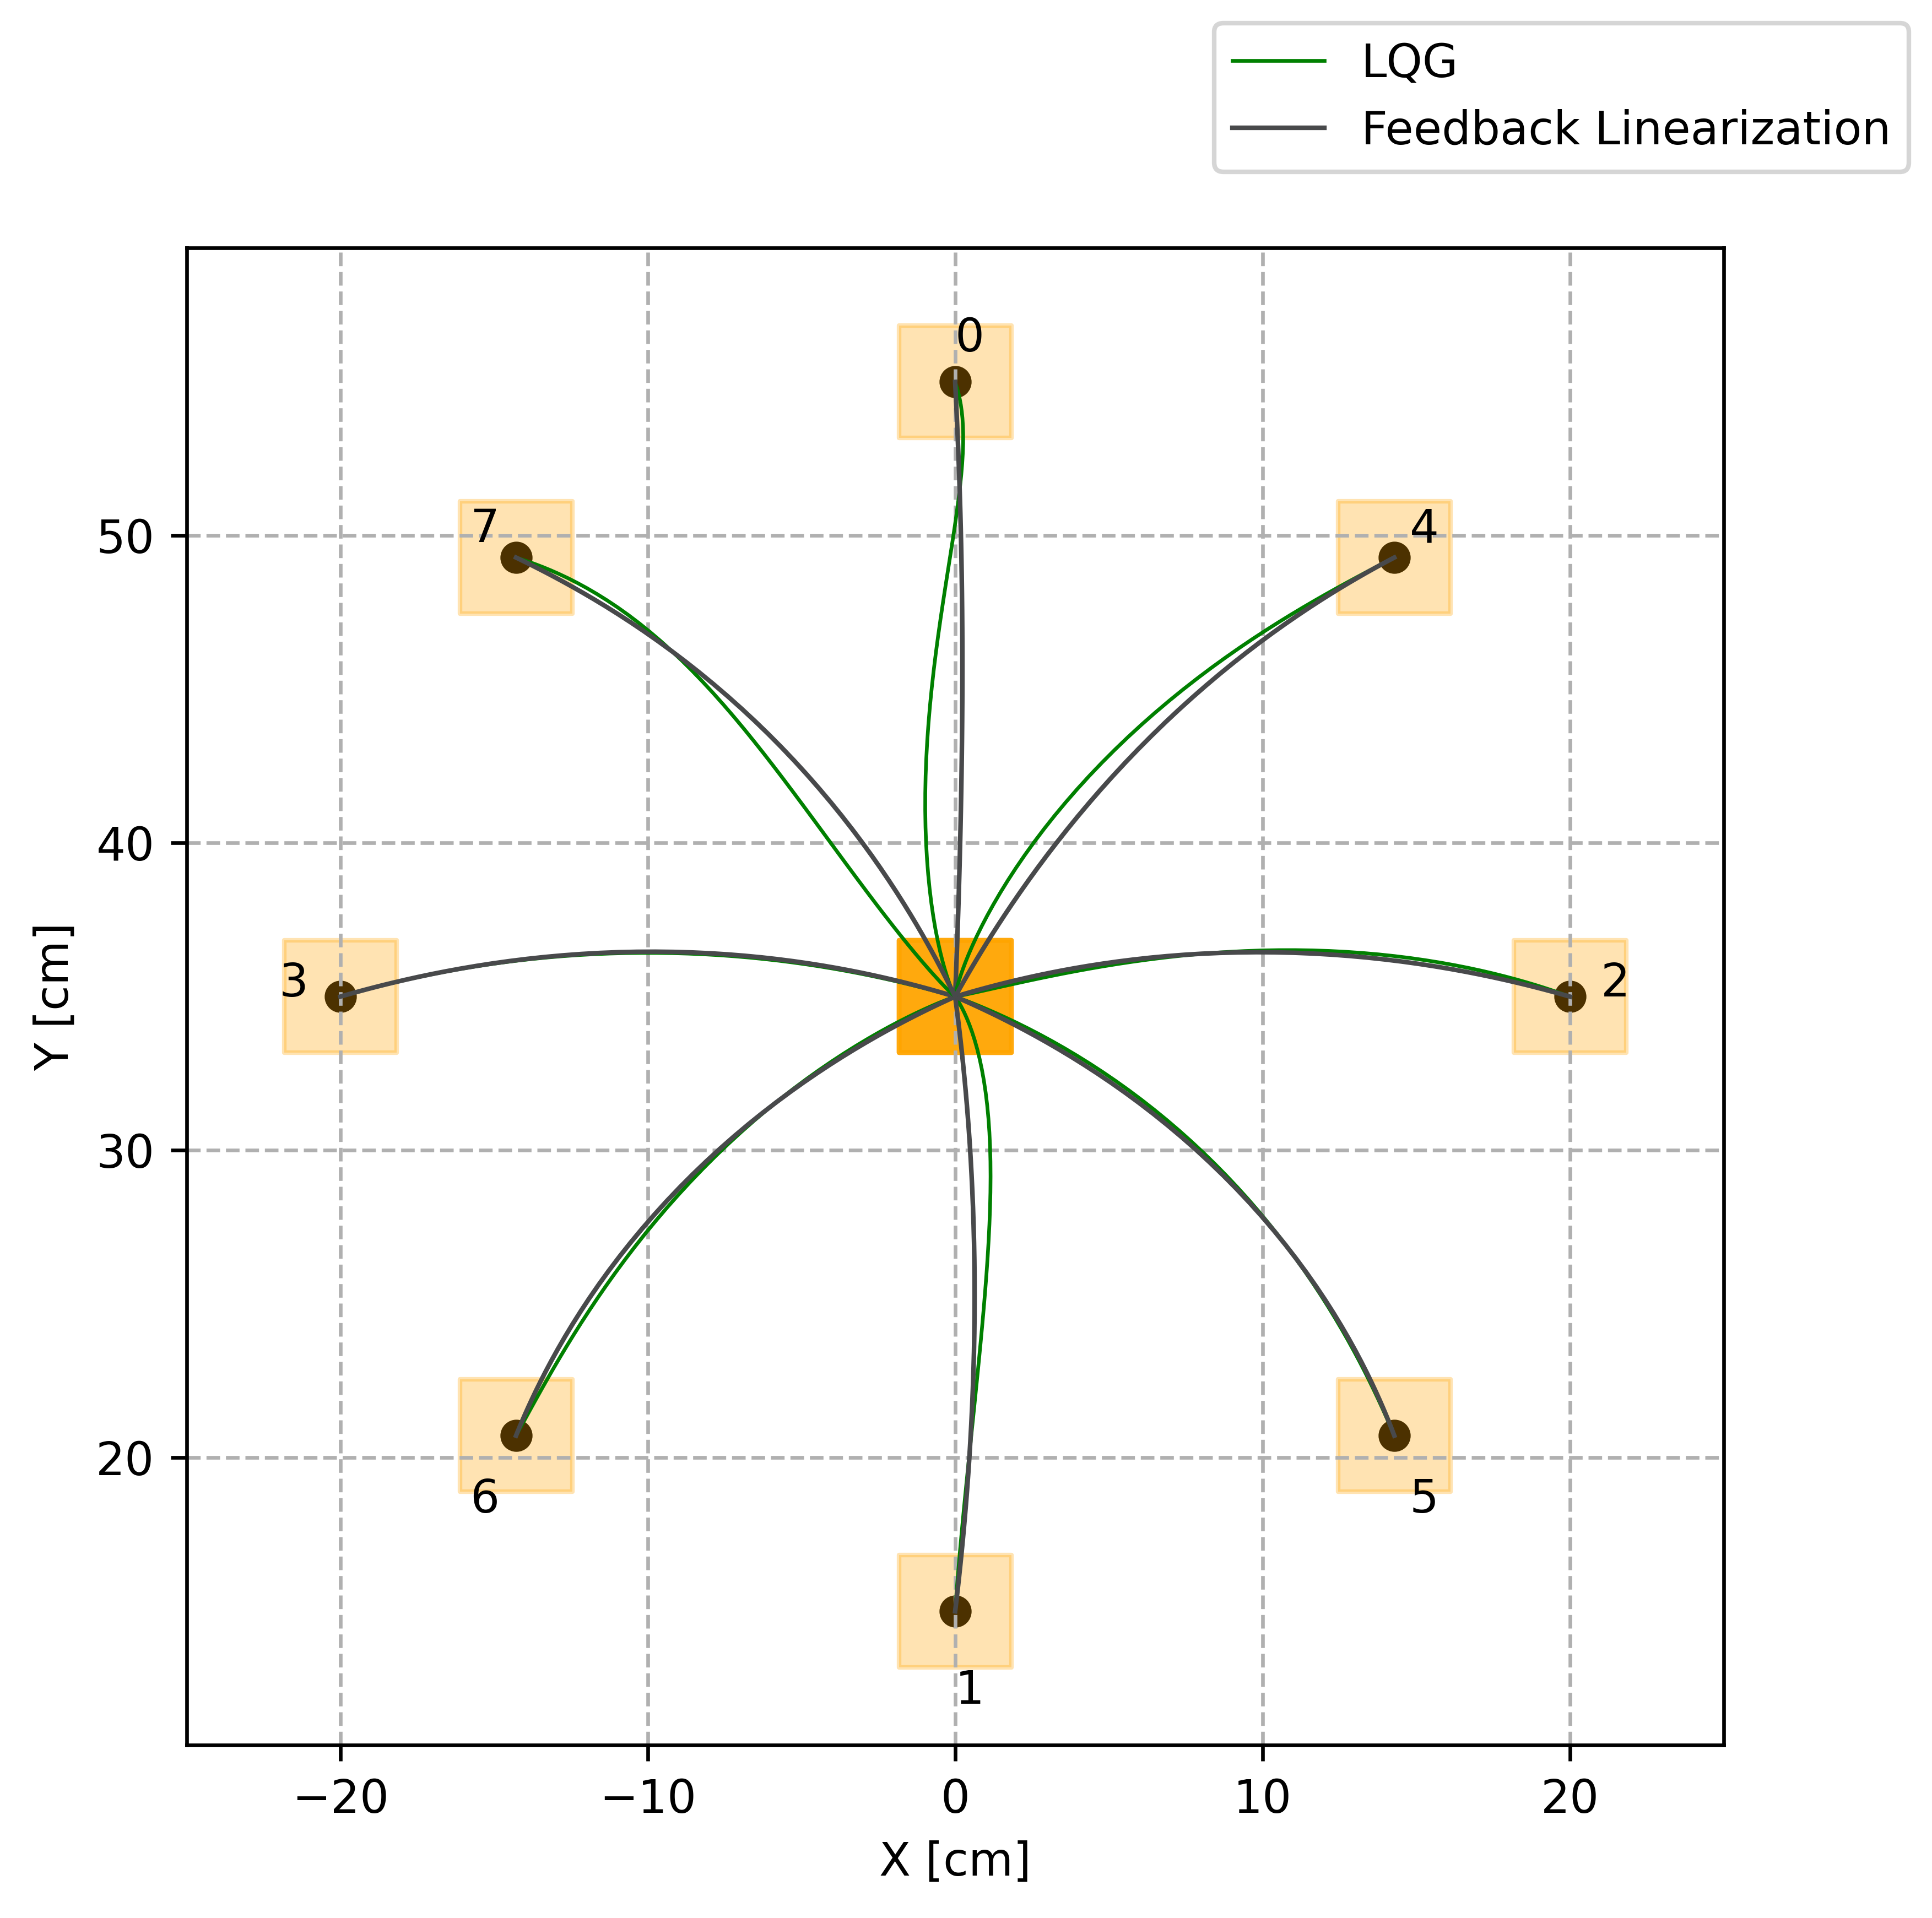

In [3]:
Plot_8_Target(Noise = False,ClassicLQG=True)

Total cost ILQG: 0.00835916054240203
Total cost of FL: 0.03528
Total cost ILQG: 0.005989986803645634
Total cost of FL: 0.01075
Total cost ILQG: 0.005467046964720924
Total cost of FL: 0.01892
Total cost ILQG: 0.009408408277047397
Total cost of FL: 0.01574
Total cost ILQG: 0.003647433901983947
Total cost of FL: 0.01221
Total cost ILQG: 0.011998602935241204
Total cost of FL: 0.01736
Total cost ILQG: 0.004878849310519756
Total cost of FL: 0.01078
Total cost ILQG: 0.011533680435456706
Total cost of FL: 0.02191


<Figure size 1440x1440 with 0 Axes>

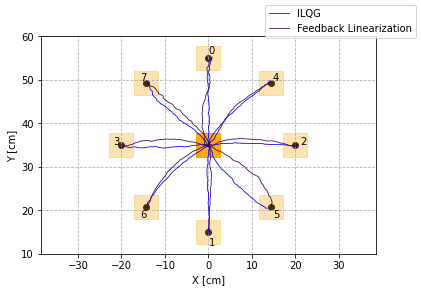

In [17]:
Plot_8_Target(Noise = True)

In [ ]:
K = 30000
Duration = .6
w1 = 1e6
w2 = 1e5
r1 = 1e-5
d = 14.285
start = [0,35]
fig,ax = plt.subplots()

TARG = [[0,55],[0,15],[20,35],[-20,35],[d,35+d],[d,35-d],[-d,35-d],[-d,35+d]]
TEXTE = [[0,56],[0,12],[21,35],[-22,35],[d+.5,35+d+.5],[d+.5,35-d-2.5],[-d-1.5,35-d-2.5],[-d-1.5,35+d+.5]]

COSTSFL = np.zeros(8)
COSTSILQG = np.zeros(8)
NUMSIM = 1
for sim in range(NUMSIM):
    for i in range(8):
        targets = TARG[i]
        obj1,obj2 = newton(fnewton,dfnewton,1e-8,1000,targets[0],targets[1])
        xtarg = np.array([obj1,obj2])
        #plt.text(TEXTE[i][0],TEXTE[i][1],str(i))
        xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,K,start,Noise = False,plot = True)
        J = 0
        R = np.array([[r1,0],[0,r1]])
        for j in range(K-1):
            J+= uILQG[j].T@R@uILQG[j]
        #J+= w1*((x[-1,0]-xtarg[0])*(x[-1,0]-xtarg[0])+(x[-1,1]-xtarg[1])*(x[-1,1]-xtarg[1])) + w2*(x[-1,2]*x[-1,2]+x[-1,3]*x[-1,3])
        COSTSILQG[i]+=(J/NUMSIM)
        X,Y,u,J = Feedback_Linearization_modified(Duration,w1,w1,w2,w2,r1,r1,targets,start,Noise_Variance=1e-32,newtonfunc = fnewton,newtondfunc = dfnewton,Num_iter = K,plot = True)
        COSTSFL[i]+=(J/NUMSIM)
        print("Finished target "+str(i))
for i in range(8):
    print("For Target Number "+str(i+1)+"\n"+"Total Cost of FL : "+str(COSTSFL[i])+"\n"+"Total Cost of ILQG : "+str(COSTSILQG[i])+"\n")

hand, labl = ax.get_legend_handles_labels()
handout=[]
lablout=[]
for h,l in zip(hand,labl):
    if l not in lablout:
        lablout.append(l)
        handout.append(h)
fig.legend(handout, lablout)
plt.ylim(10,60)
plt.show()

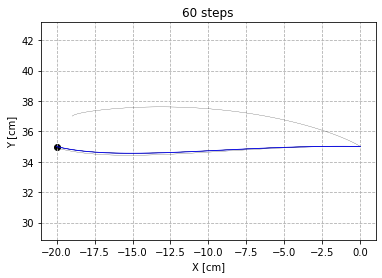

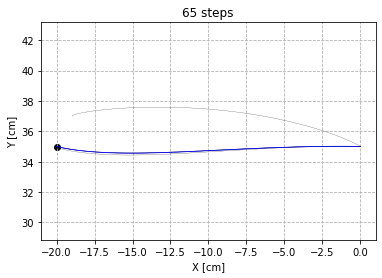

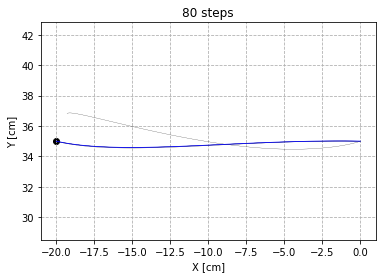

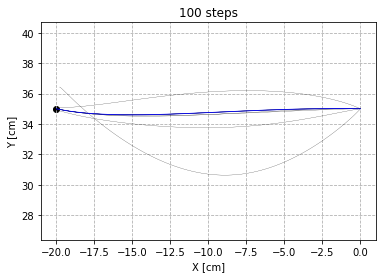

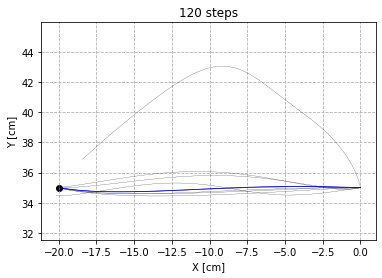

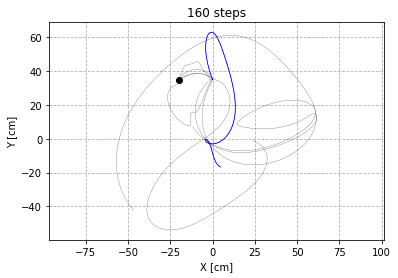

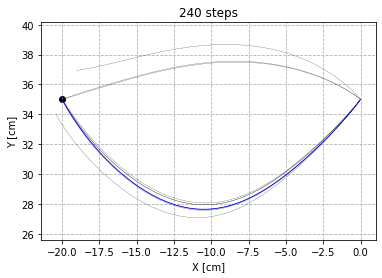

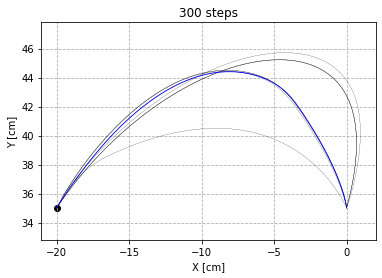

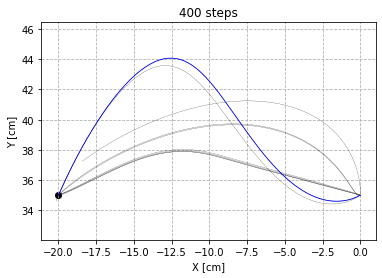

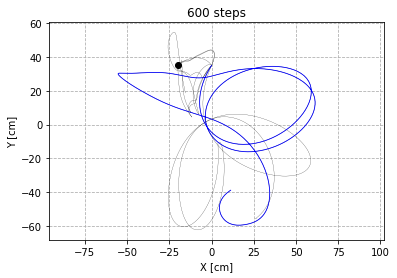

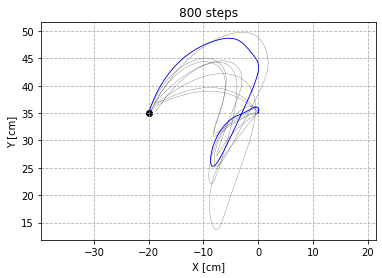

In [ ]:

targets = TARG[3]
obj1,obj2 = newton(fnewton,dfnewton,1e-8,1000,targets[0],targets[1])
xtarg = np.array([obj1,obj2])
#[60,65,80,100,120,160,240,300,400,600]
for K in [60,65,80,100,120,160,240,300,400,600,800]:
    plt.title(str(K)+" steps")
    xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,K,start,Noise = False,plot = True,plotall = True,B = False)
    plt.show()
        

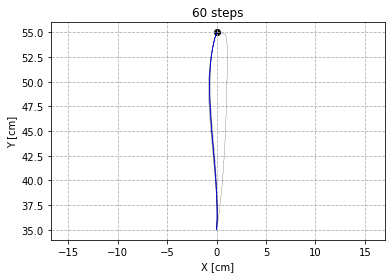

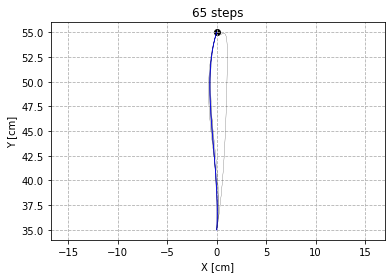

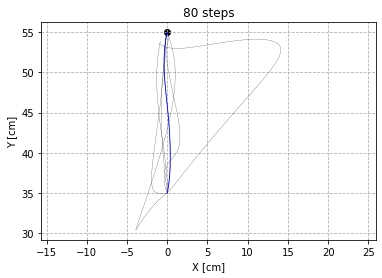

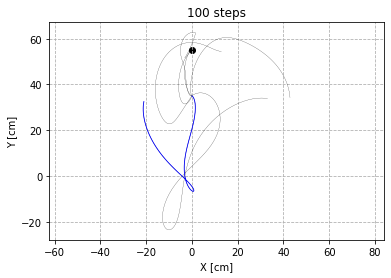

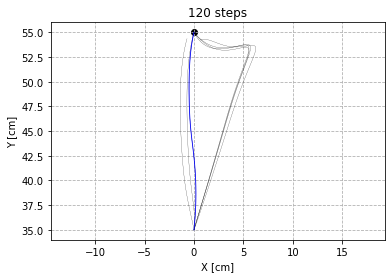

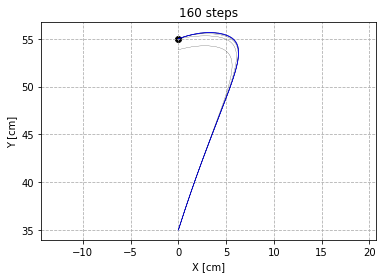

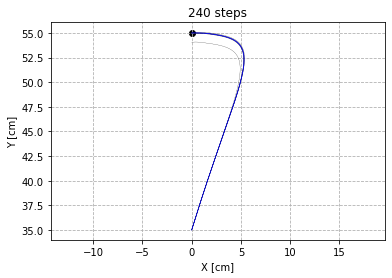

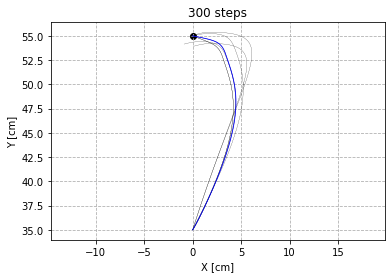

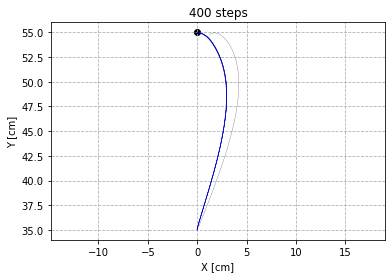

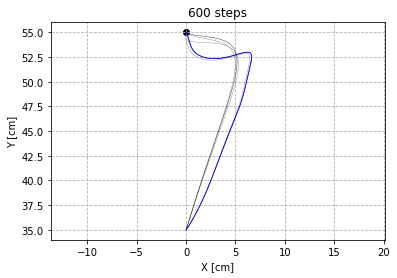

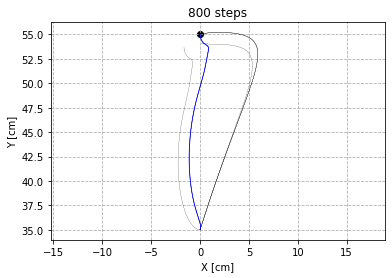

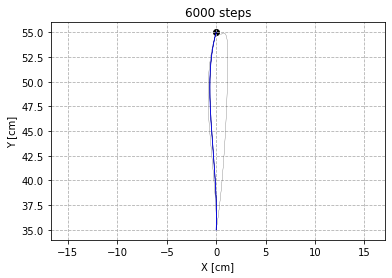

In [ ]:

targets = TARG[0]
obj1,obj2 = newton(fnewton,dfnewton,1e-8,1000,targets[0],targets[1])
xtarg = np.array([obj1,obj2])
#[60,65,80,100,120,160,240,300,400,600]
for K in [60,65,80,100,120,160,240,300,400,600,800,6000]:
    plt.title(str(K)+" steps")
    xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,K,start,Noise = False,plot = True,plotall = True,B = False)
    plt.show()

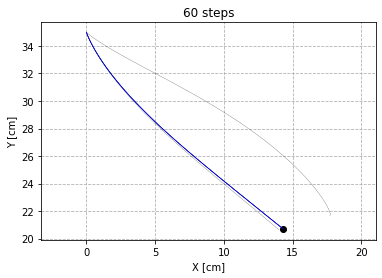

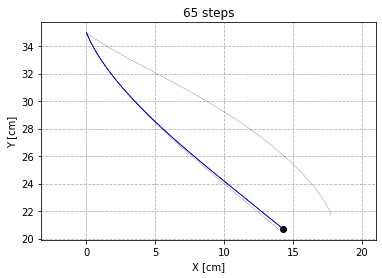

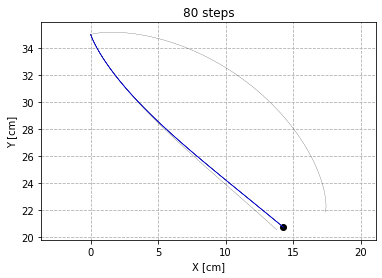

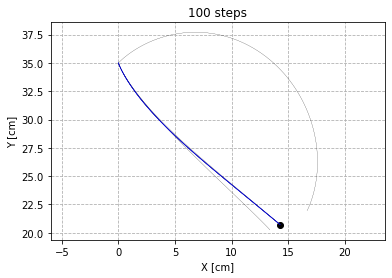

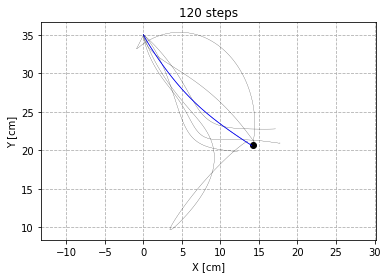

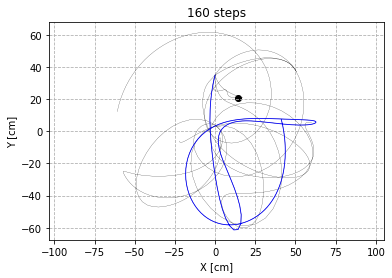

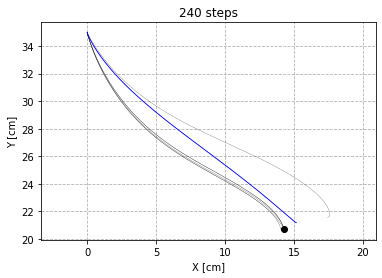

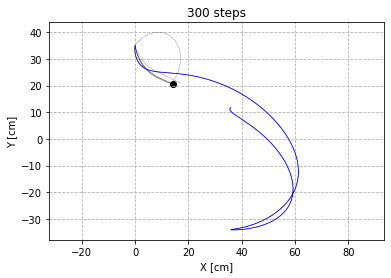

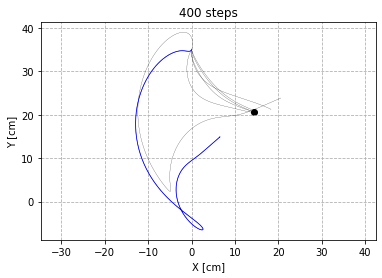

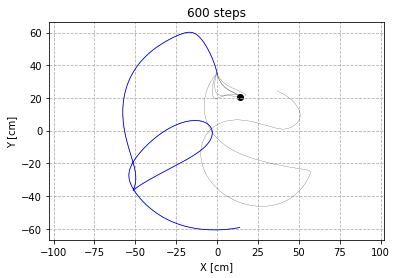

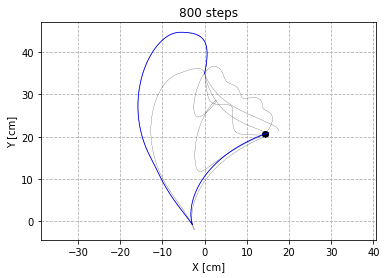

In [ ]:
targets = TARG[5]
obj1,obj2 = newton(fnewton,dfnewton,1e-8,1000,targets[0],targets[1])
xtarg = np.array([obj1,obj2])
#[60,65,80,100,120,160,240,300,400,600]
for K in [60,65,80,100,120,160,240,300,400,600,800,1600]:
    plt.title(str(K)+" steps")
    xILQG,yILQG,uILQG,x = ILQG(Duration,w1,w2,r1,targets,K,start,Noise = False,plot = True,plotall = True,B = False)
    plt.show()